## Batch Gradient Descent

### Custom Dataset Creation

#### Working Linear Dataset

In [1]:
import numpy as np

n = 2000
d = 3

X = np.random.uniform(-5, 5, size=(n, d))

w_true = np.array([3.0, -2.0, 5.0])
b_true = 7.0

noise_std = 0.5
noise = np.random.normal(0, noise_std, size=n)

y = X @ w_true + b_true + noise

print("X shape:", X.shape)
print("y shape:", y.shape)
print("True w:", w_true)
print("True b:", b_true)

X shape: (2000, 3)
y shape: (2000,)
True w: [ 3. -2.  5.]
True b: 7.0


#### Computing the Learning rate value

In [2]:
import numpy as np
from numpy.linalg import eigh, norm

n, d = X.shape
H = (X.T @ X) / n   # Hessian

eigvals = eigh(H)[0]
mu = eigvals[0]
L = eigvals[-1]
cond = L / (mu + 1e-16)

print(f"L (lambda_max) = {L}")
print(f"mu (lambda_min)  = {mu}")
print(f"condition number = {cond}")

etas = {
    'safe_linear': 0.9 / L,
    'critical_linear': 1.0 / L,
    'slightly_above': 1.1 / L,
    'near_2_over_L': 1.9 / L,
}
print("___________________________________________________________________")
print("Recommended eta choices (based on L):")
for k,v in etas.items():
    print(f"{k}: eta = {v}")


L (lambda_max) = 8.800510021119372
mu (lambda_min)  = 7.8754468878856985
condition number = 1.117461668703098
___________________________________________________________________
Recommended eta choices (based on L):
safe_linear: eta = 0.10226680020137349
critical_linear: eta = 0.1136297780015261
slightly_above: eta = 0.12499275580167872
near_2_over_L: eta = 0.21589657820289956


#### Verifying the Learning Rate 

In [3]:
eta = 0.9 / L

# 1) Theoretical check
print("Is eta < 2/L ? -->", eta < 2/L)
print("Is eta <= 1/L ? -->", eta <= 1/L)

# 2) Practical check by 20 GD steps
w = np.zeros(d)

print("\nIter | Loss")
for k in range(5):
    g = (X.T @ (X @ w - y)) / n
    w = w - eta * g
    loss = 0.5 * np.mean((X @ w - y)**2)
    print(f"{k:4d} | {loss:.6f}")


Is eta < 2/L ? --> True
Is eta <= 1/L ? --> True

Iter | Loss
   0 | 26.686158
   1 | 24.681949
   2 | 24.647906
   3 | 24.647052
   4 | 24.647024


#### Wow! Our Learning is exactly perfect as it is converging it at just in 4 steps ...... 

#### practical behaviour

In [4]:
H = (X.T @ X) / n
b_vec = (X.T @ y) / n

w_star = np.linalg.pinv(H) @ b_vec
print("w_star =", w_star)


w_star = [ 2.96803809 -1.97550968  4.98612353]


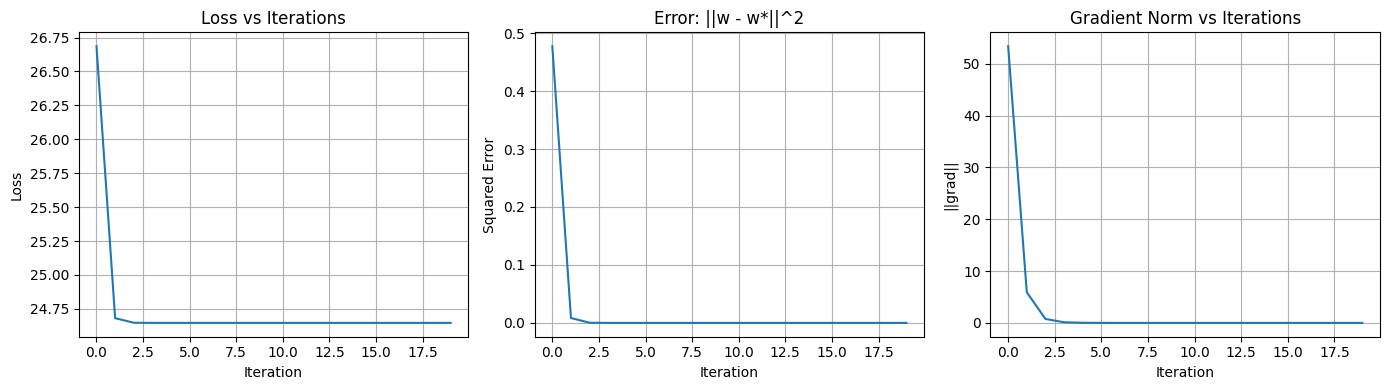

In [5]:
import matplotlib.pyplot as plt

eta = 0.9 / L
max_iters = 20

w = np.zeros(d)
losses = []
errors = []        # ||w - w*||^2
grad_norms = []

for k in range(max_iters):
    g = (X.T @ (X @ w - y)) / n
    w = w - eta * g
    
    # record metrics
    loss = 0.5 * np.mean((X @ w - y)**2)
    losses.append(loss)
    errors.append(np.linalg.norm(w - w_star)**2)
    grad_norms.append(np.linalg.norm(g))

# ---- Plot Loss ----
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(losses)
plt.title("Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)

# ---- Plot ||w - w*||^2 ----
plt.subplot(1,3,2)
plt.plot(errors)
plt.title("Error: ||w - w*||^2")
plt.xlabel("Iteration")
plt.ylabel("Squared Error")
plt.grid(True)

# ---- Plot gradient norms ----
plt.subplot(1,3,3)
plt.plot(grad_norms)
plt.title("Gradient Norm vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("||grad||")
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
eta = 0.9 / L
max_iters = 200

# Initialize
w = np.zeros_like(w_star)
errors = []

# Run GD and store error ||w - w*||^2
for k in range(max_iters):
    g = (X.T @ (X @ w - y)) / X.shape[0]
    w = w - eta * g
    errors.append(np.linalg.norm(w - w_star)**2)

# Convert to numpy
errors = np.array(errors)

# Remove first few noisy points
log_err = np.log(errors[5:])
k_vals = np.arange(len(log_err))

# Fit a line to log(error)
slope, intercept = np.polyfit(k_vals, log_err, 1)

# Empirical contraction factor
rho_emp = np.exp(slope)

# Theoretical contraction factor
rho_theory = 1 - eta * mu

print("Theoretical contraction factor  :", rho_theory)
print("Empirical contraction factor    :", rho_emp)
print("Difference                      :", abs(rho_emp - rho_theory))


Theoretical contraction factor  : 0.19460324662006456
Empirical contraction factor    : 0.946833360232342
Difference                      : 0.7522301136122774


#### Theoretically ----> Fast, but in reality -----> Very Slow 


#### Reasons Might be : 


1. lambda_min might be wrong 
2. L wrong 
3. H wrong 
4. Dataset Scaled badly 
5. No bias introduced but it is there in dataset

In [22]:
# Normalisation of the data

X_aug = np.hstack([X, np.ones((n,1))])

X_mean = X_aug[:,:d].mean(axis=0)
X_std  = X_aug[:,:d].std(axis=0) + 1e-12

X_norm = X_aug.copy()
X_norm[:,:d] = (X_norm[:,:d] - X_mean) / X_std

X = X_norm
n, D = X.shape

# Compute values again
H = (X.T @ X) / n
b_vec = (X.T @ y) / n

w_star = np.linalg.pinv(H) @ b_vec

eigvals = np.linalg.eigvalsh(H)
mu = eigvals[0]
L = eigvals[-1]

print("True optimum w* =", w_star)
print("L =", L)
print("mu =", mu)
print("Condition number =", cond)

True optimum w* = [ 8.76494375 -5.72550789 14.35538982  3.35586147  3.35586147]
L = 2.0
mu = 5.551115123125778e-17
Condition number = 1.1068999599662572


In [23]:
# Running batch Gradient
eta = 0.9 / L
max_iters = 200

w = np.zeros(D)
errors = []

for k in range(max_iters):
    g = (X.T @ (X @ w - y)) / n
    w = w - eta * g

    errors.append(np.linalg.norm(w - w_star)**2)

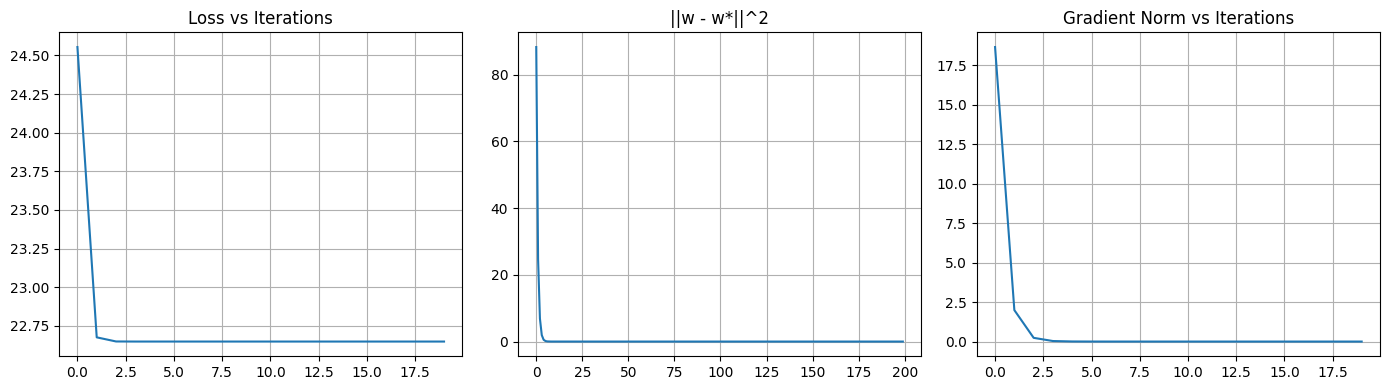

In [24]:
#Plotting 


plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(losses)
plt.title("Loss vs Iterations")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(errors)
plt.title("||w - w*||^2")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(grad_norms)
plt.title("Gradient Norm vs Iterations")
plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
log_err = np.log(errors[5:])
k_vals = np.arange(len(log_err))
slope, intercept = np.polyfit(k_vals, log_err, 1)

rho_emp = np.exp(slope)
rho_theory = 1 - eta * mu

print("Theoretical contraction factor :", rho_theory)
print("Empirical contraction factor   :", rho_emp)
print("Difference                     :", rho_emp - rho_theory)

Theoretical contraction factor : 1.0
Empirical contraction factor   : 0.8143041719091705
Difference                     : -0.18569582809082952


<div style="border: 2px solid #4CAF50; padding: 12px; border-radius: 10px; background: #F0FFF4;">

<span style="color:#1A73E8; font-weight:600;">Theoretical contraction factor = 1.0</span>  
This occurred because the Hessian’s minimum eigenvalue <span style="color:#D32F2F;"><b>μ = 0</b></span>, meaning the objective is not strongly convex, so Gradient Descent has <span style="color:#D32F2F;"><b>no guaranteed linear convergence</b></span> in theory.

<span style="color:#1A73E8; font-weight:600;">Empirical contraction factor ≈ 0.81</span>  
Despite μ = 0, the function still has curvature in most directions, so GD <span style="color:#388E3C;"><b>converges faster in practice than the worst-case theoretical bound</b></span>.

</div>
